# 1. Mô tả bài toán 
Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi để những người khác tương tác, đưa ra những câu trả lời chất lượng. Bài toán đặt ra là làm thế nào để loại bỏ những câu hỏi thiếu thành thật (insincere question) - những câu hỏi dựa trên những định kiến sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích

### Các thư viện được sử dụng

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS



In [ ]:
!pip install nltk==3.4 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer


# 2. Phân tích dữ liệu
## 2.1 Tổng quan về dữ liệu

In [ ]:
# Load dữ liệu huấn luyện và dữ liệu test bằng hàm read_csv từ thư viện pandas
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_df = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

print('Số lượng điểm dữ liệu ở trong tập huấn luyện:', train_df.shape[0])
print('Số lượng điểm dữ liệu ở trong tập test:', test_df.shape[0])


In [ ]:
# Xem dữ liệu huấn luyện
train_df.head(10)

Bộ dữ liệu huấn luyện gồm 3 cột: qid, question_text (nội dung câu hỏi) và target (là giá trị nhị phân 0,1, với 0 là sincere question, 1 là insincere question)

In [ ]:
# kiểm tra các điểm dữ liệu trong dữ liệu huấn luyện có giá trị null nào không
print('Số giá trị null ở cột qid, question_text, target:', train_df['qid'].isnull().sum(),',',
                                                            train_df['question_text'].isnull().sum(),',',
                                                            train_df['target'].isnull().sum())


In [ ]:
# Xem các sincere question ở trong dữ liệu huấn luyện
train_df[train_df['target']==0].head(5)

In [ ]:
#Xem các insincere question ở trong dữ liệu huấn luyện
train_df[train_df['target']==1].head(5)

In [ ]:
#Xem dữ liệu test
test_df.head(10)

## 2.2. Trực quan hóa dữ liệu

## 2.2.1 Trực quan hóa dữ liệu trong tập huấn luyện

#### Số lượng các câu hỏi ở mỗi loại trong tập training

In [ ]:
train_df['target'].value_counts() # Với 0 là sincere question, 1 là insincere question

#### Trực quan hóa số lượng các câu hỏi thông qua bar chart và pie chart

In [ ]:
# Biểu đồ số lượng các câu hỏi
plt.subplot(1, 2, 1)
train_df.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Question Count')
plt.subplots_adjust(right=1.9)

# Biểu đồ phân phối các câu hỏi 
plt.subplot(1, 2, 2)
values = [train_df[train_df['target']==0].shape[0], train_df[train_df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Question Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)

plt.show()

Bộ dữ liệu huấn luyện có sự mất cân bằng khi 93,8% () là các câu hỏi sincere, 6,2% còn lại là insincere question. Ta cần có giải pháp cân bằng lại dữ liệu trong tập training

### 2.2.1.1. Các từ có tần suất xuất hiện nhiều nhất trong sincere và insincere questions

In [ ]:
def pltTopWord(data, title, bar_color, numberOfWordsInTop):
    
  top_words = Counter(data).most_common(numberOfWordsInTop) # 25 từ xuất hiện nhiều nhất

  df_top = pd.DataFrame(top_words, columns=['word', 'count']).sort_values('count')

  plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=bar_color)
  plt.title(f'Top words in {title}')



Ta sử dụng phương pháp N-grams để tìm các từ/ cụm từ có tần suất được sử dụng nhiều nhất trong từng loại câu hỏi. 
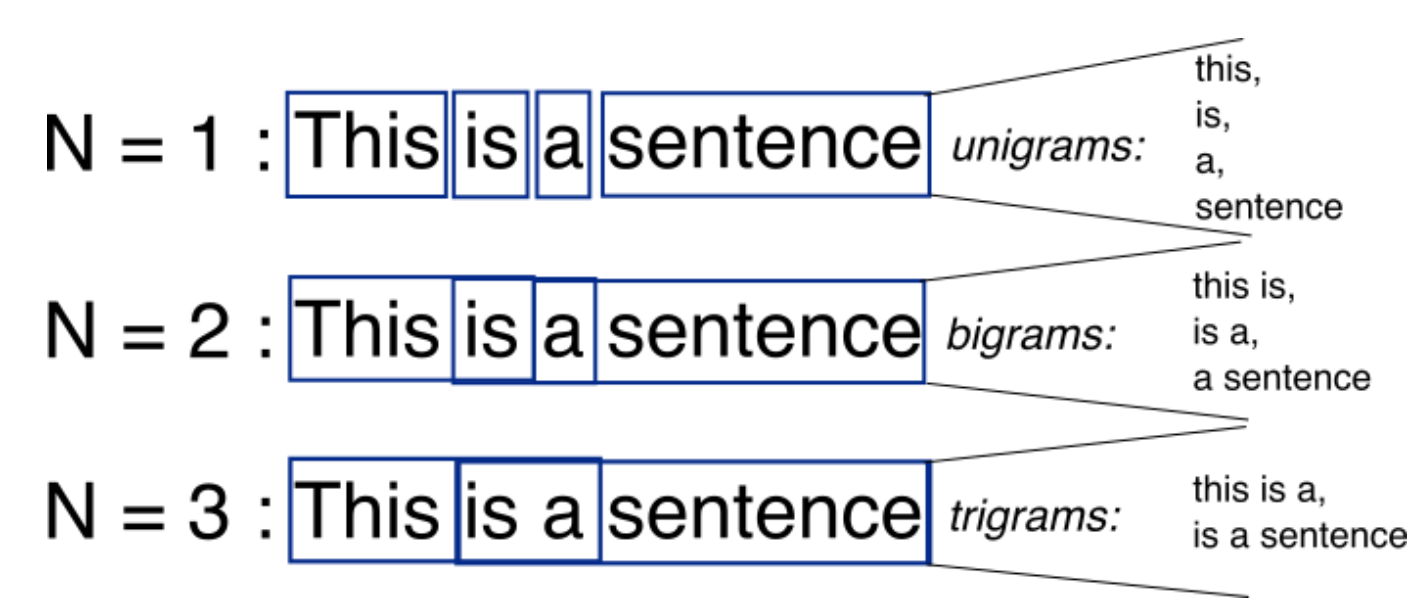

Ở đây, ta sử dụng 1-grams (unigrams) và 2-grams (bigrams)

In [ ]:
def get_unigrams(data):
  unigrams = []
  for sent in data:
    unigrams.extend([w for w in sent.lower().split() if w not in STOPWORDS]) # không lấy các từ stopword
  return unigrams

def get_bigrams(data):
  bigrams = []
  for question in data:
    question = [w for w in question.lower().split() if w not in STOPWORDS] # không lấy các từ stopword
    if not question: 
        continue # tránh việc mảng question rỗng gây ra lỗi khi dùng nltk.bigrmas
    bi = [b for b in nltk.bigrams(question)]
    bi = [' '.join(w) for w in bi]
    bigrams.extend(bi)
  return bigrams

In [ ]:
unigrams_sincere  = get_unigrams(train_df[train_df['target']==0]['question_text'])
unigrams_insincere = get_unigrams(train_df[train_df['target']==1]['question_text'])


In [ ]:
plt.subplot(1, 2, 1)
pltTopWord(unigrams_sincere, 'Sincere questions: Unigrams', 'blue',25)


plt.subplot(1, 2, 2)
pltTopWord(unigrams_insincere, 'Insincere questions: Unigrams', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

In [ ]:
bigrams_sincere = get_bigrams(train_df[train_df['target']==0]['question_text'])
bigrams_insincere = get_bigrams(train_df[train_df['target']==1]['question_text'])

In [ ]:
plt.subplot(1, 2, 1)
pltTopWord(bigrams_sincere, 'Sincere questions: Bigrams', 'blue',25)

plt.subplot(1, 2, 2)
pltTopWord(bigrams_insincere, 'Insincere questions: Bigrams', 'red',25)

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

Sau khi loại bỏ các stopwords, với các sincere question, các từ xuất hiện nhiều nhất thường là những từ mang nghĩa tích cực như: best, possible, people, etc. Với các insincere question, các từ xuất hiện nhiều nhất thường là: donald trump, black, indian.

### 2.2.1.2 Một vài đặc trưng cơ bản 

#### Bổ sung các đặc trưng 

Ta sẽ thêm một vài đặc trưng cơ bản của câu hỏi vào trong tập training:
* Độ dài của câu
* Số lượng từ 
* Số lượng từ không trùng nhau
* Số lượng các stopwords
* Số lượng ký tự đặc biệt (ở đây, các ký tự ngoài chữ,số, dấu space, ta coi là các ký tự đặc biệt)

In [ ]:
special_character_list = []
def count_special_character_in(text):
    count = 0
    for i in range(0, len(text)):
        if(text[i].isalpha() or text[i] ==' '):
            continue
        elif(text[i].isdigit()):
            continue   
        else:
            special_character_list.extend(text[i])
            count+=1
    return count



# Độ dài của câu
train_df['question_length'] = train_df['question_text'].apply(lambda ques: len(str(ques)))

# Số lượng từ của câu
train_df['number_of_words'] = train_df['question_text'].apply(lambda ques: len(str(ques).split()))

#Số lượng từ không trùng nhau của câu
train_df['number_of_unique_words'] = train_df['question_text'].apply(lambda ques: len(set(str(ques).split())))

#Số lượng các stopwords
train_df['number_of_stopwords'] = train_df['question_text'].apply(lambda ques: len([w for w in str(ques).lower().split() if w in STOPWORDS]))

#Số lượng các ký tự đặc biệt
train_df['number_special'] = train_df['question_text'].apply(lambda ques: count_special_character_in(ques))

special_character_list = set(special_character_list)
print(list(set(special_character_list)))

train_df.head(5)


#### Phân tích các đặc trưng

Ta sử dụng box plot để phân tích các đặc trưng. Box plot là một dạng biểu đồ thể hiện phân phối dữ liệu các thuộc tính thông qua các tứ phân vị. Box plot thể hiện các phân phối dữ liệu, giúp ta biết độ phân bố của các điểm dữ liệu như thế nào, dữ liệu có phân bố rộng hay hẹp, giá trị lớn nhất và các điểm ngoại lệ.

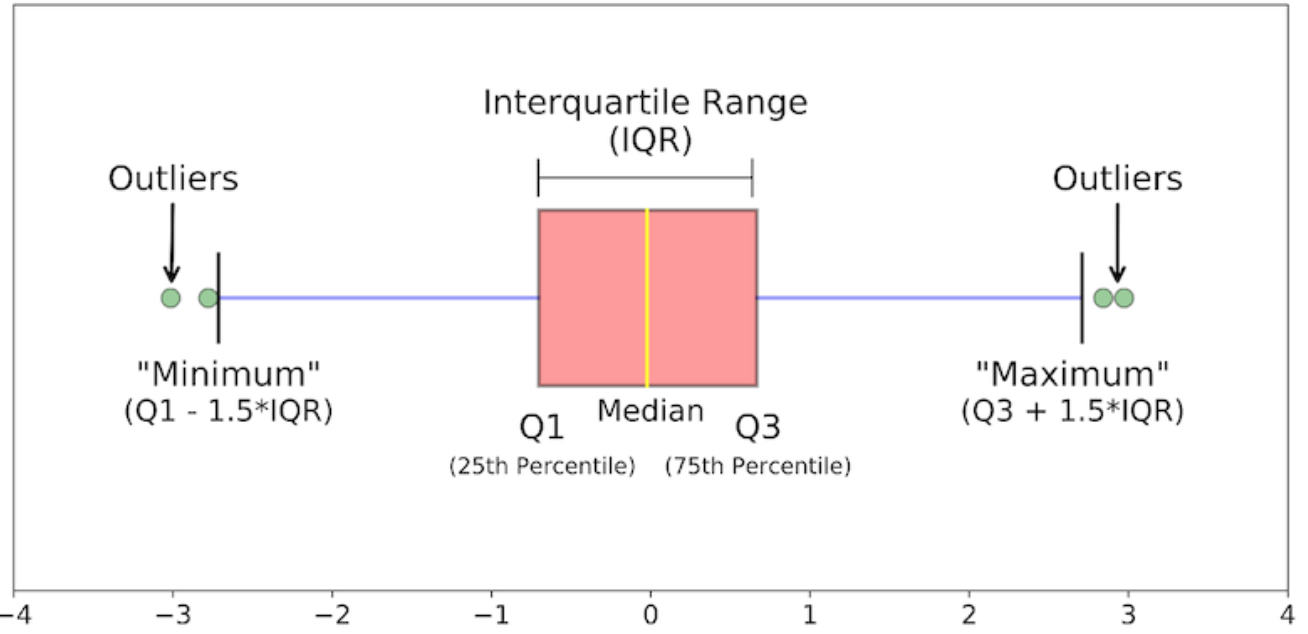

Biểu đồ Boxplot thể hiện 6 thông số:
* Median: Trung vị của tập dữ liệu, tức là giá trị ở phần tử giữa
* First quartile (Q1): Trung vị giữa Median và phần tử nhỏ nhất trong tập dữ liệu. Còn gọi là 25th Percentile.
* Third quartile (Q3): Trung vị giữa Median và phần tử lớn nhất trong tập dữ liệu. Còn gọi là 75th Percentile.
* Minimum: Phần tử nhỏ nhất không phải ngoại lệ.
* Maximum: Phần tử lớn nhất không phải là ngoại lệ.
* Outliers: Các ngoại lệ, là các điểm dữ liệu khác biệt đáng kể so với các điểm dữ liệu còn lại



In [ ]:
import seaborn as sb

In [ ]:
def boxPlot(x,y,data,title):
    sb.boxplot(x=x,y=y,data=data)
    plt.grid(True)
    plt.title(title)

# boxplot: Độ dài của câu
plt.subplot(2,3,1)
boxPlot('target', 'question_length', train_df, 'question_length of each question class')

# boxplot: Số lượng từ
plt.subplot(2,3,2)
boxPlot('target', 'number_of_words', train_df, 'number_of_words of each question class')

# boxplot: Số lượng từ không bị trùng
plt.subplot(2,3,3)
boxPlot('target', 'number_of_unique_words', train_df, 'number_of_unique_words of each question class')

# boxplot: Số lượng stopwords
plt.subplot(2,3,4)
boxPlot('target', 'number_of_stopwords', train_df, 'number_of_stopwords of each question class')

# boxplot: Số lượng ký tự đặc biệt
plt.subplot(2,3,5)
boxPlot('target', 'number_special', train_df, 'number_special of each question class')

plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()





**Nhận xét**:
* Các insincere question có độ dài câu hỏi, số lượng từ, số lượng ký tự đặc biệt nhìn chung lớn hơn so với các sincere question (ngoại trừ một vài outliers của sincere).
    * insincere có thể là các câu hỏi spam, quảng cáo,...
    * Dựa vào số lượng ký hiệu đặc biệt, insincere có thể là các công thức toán học latex, các câu hỏi chứa các icon,... 
* Ta nhìn thấy outliers ở boxplot question_length của sincere xấp sỉ 800. Ta sẽ xem đây là câu hỏi như nào. Đồng thời ta sẽ xem câu hỏi có độ dài lớn nhất là 1000 của insincere là câu hỏi như nào.


#### Phân tích đặc trưng độ dài

In [ ]:
train_df_insincere = pd.DataFrame(train_df[train_df['target']==1], columns =['question_text','target','question_length'])
train_df_insincere.head()

In [ ]:
# Sort tập training ở lớp insincere từ lớn đến nhỏ 
train_df_insincere.sort_values('question_length', inplace = True, ascending = False)
train_df_insincere.head(10)

In [ ]:
def topQuestionIn(data,noOfQues):
    listTop = data.tolist()
    for i in range(0,noOfQues):
        print('Question',i)
        print(listTop[i]+'\n')

Ta in ra 10 câu hỏi dài nhất ở lớp insincere

In [ ]:
  topQuestionIn(train_df_insincere['question_text'],10)  

In [ ]:
# Làm tương tự với lớp sincere
train_df_sincere = pd.DataFrame(train_df[train_df['target']==0], columns =['question_text','target','question_length'])
train_df_sincere.sort_values('question_length', inplace = True, ascending = False)

topQuestionIn(train_df_sincere['question_text'],10)  



**Nhận xét:** 
* Ta thấy câu có độ dài lớn nhất của insincere là được viết bằng công thức toán học Latex
* Câu hỏi có độ dài 800 từ của sincere là một câu hỏi liên quan đến phim ảnh, còn câu hỏi có độ dài thứ nhì là một câu hỏi toán học Latex 
* Ta chuyển đổi 3 câu hỏi toán học ở trong top các từ dài nhất ở 2 lớp sang dạng latex view: 
    * 2 hình ảnh ở lớp insincere:
    
    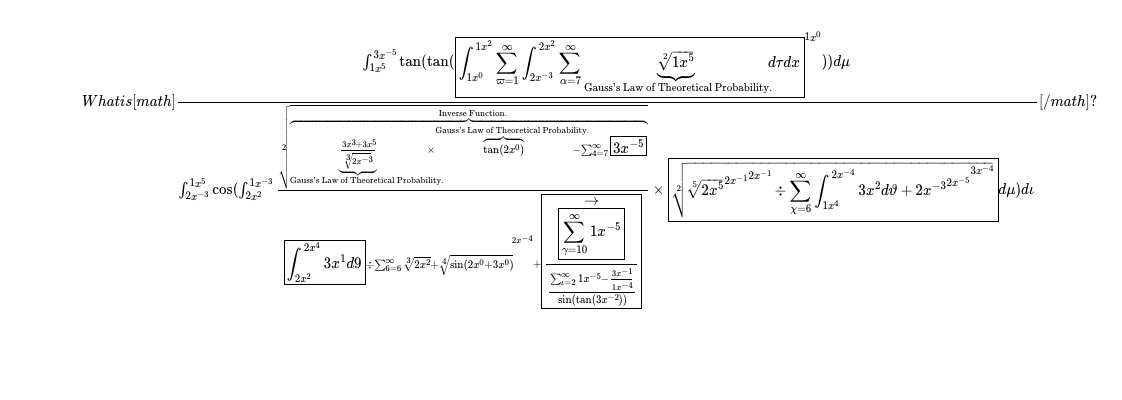
    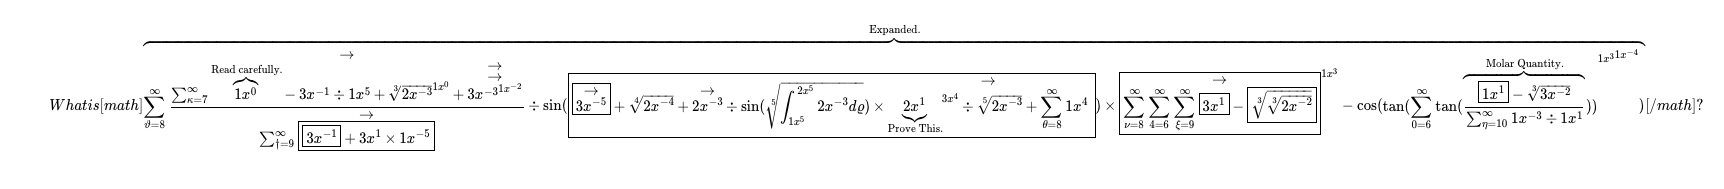
    
    * hình ảnh ở lớp sincere:
    
    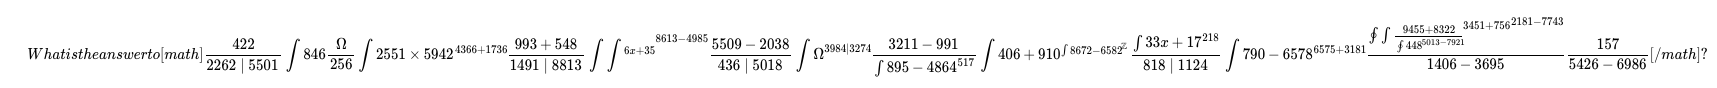
    
* Ta thấy các câu hỏi toán học được đánh dấu ở hai lớp ở trên không có vấn đề gì đáng ngờ. Tuy nhiên có khả năng vì nhiều ký tự đặc biệt nên chúng bị đánh dấu insincere
    
    
    


# 3. Tiền xử lý và clean dữ liệu 

Quá trình tiền xử lý dữ liệu gồm:
* Loại bỏ các ký tự đặc biệt có trong câu hỏi
* Xử lý các misspell words (các từ viết/phát âm không chính xác)
* Xử lý các Contractions (những từ có dấu nháy đơn ['])
* Loại bỏ các stopwords
* Lemmatization: là quá trình thay thế các từ bằng từ gốc trong từ điển
* Tokenize 

In [ ]:
#unzip file embedding 
#!unzip ../input/quora-insincere-questions-classification/embeddings.zip

In [ ]:
# Loại bỏ các ký tự đặc biệt
def remove_special_character(text):
    text = str(text)
    for c in special_character_list: # special_character_list khi chạy boxplot ký tự đặc biệt
        if c in text:
            text = text.replace(c,'')
    return text

In [ ]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

In [ ]:
#Loại bỏ các stopwords
def remove_stopwords(text):
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

In [ ]:
#Xử lý các contraction
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_map[t] if t in contraction_map else t for t in text.split(" ")])
    return text
    

In [ ]:
#Lemamatizing

word_lemmatizer = WordNetLemmatizer()
def lemma_word(text):
    text = text.split()
    text =[word_lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text)


In [ ]:
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [ ]:
def clean_data(text):
    text = clean_tag(text)
    text = remove_special_character(text)
    text = correct_mispell(text)
    text = remove_stopwords(text)
    text = clean_contractions(text)
    text = lemma_word(text)
    return text 


In [ ]:

train_df['preprocessed_question_text'] = train_df['question_text'].apply(lambda x: clean_data(x))
test_df['preprocessed_question_text'] = test_df['question_text'].apply(lambda x: clean_data(x))



In [ ]:
train_df.head(20)

In [ ]:
test_df.head(20)

# 4. Chia training set với 80% cho train, 20% cho test

In [ ]:
from sklearn.model_selection import train_test_split

y = train_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(train_df,y, test_size =0.2, random_state = 2019)
X_train, X_val, y_train,y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 2019)

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ',X_test.shape, y_test.shape)
print('X_val: ',X_val.shape, y_val.shape)




#### Bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer()

vectorizer_bow.fit_transform(list(train_df['preprocessed_question_text'].values) + list(test_df['preprocessed_question_text'].values))

X_train_bow = vectorizer_bow.transform(X_train['preprocessed_question_text'].values)
X_test_bow = vectorizer_bow.transform(X_test['preprocessed_question_text'].values)
X_val_bow = vectorizer_bow.transform(X_val['preprocessed_question_text'].values)
print(X_train_bow.shape)
print(X_test_bow.shape)
print(X_val_bow.shape)

#### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

vectorizer_tfidf.fit_transform(list(train_df['preprocessed_question_text'].values) + list(test_df['preprocessed_question_text'].values))

X_train_tfidf = vectorizer_tfidf.transform(X_train['preprocessed_question_text'].values)
X_test_tfidf = vectorizer_tfidf.transform(X_test['preprocessed_question_text'].values)
X_val_tfidf = vectorizer_tfidf.transform(X_val['preprocessed_question_text'].values)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_val_tfidf.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

logisticRegression_model_tfidf = LogisticRegression(C = 1.0,solver ='liblinear')
logisticRegression_model_tfidf.fit(X_train_tfidf, y_train)

In [ ]:
y_predict_1 = logisticRegression_model_tfidf.predict_proba(X_test_tfidf)[:,1]

for t in np.arange(0.1, 0.3, 0.01):
    t = np.round(t, 2)
    
    print('F1 score at threshold {0} is {1}'.format(t, f1_score(y_test, (y_predict_1>t).astype('int'))))

In [ ]:
X_test = vectorizer_tfidf.transform(test_df['preprocessed_question_text'].values)
Y_pre = logisticRegression_model_tfidf.predict(X_test)

In [ ]:
logisticRegression_model_bow = LogisticRegression(C = 1.0,solver ='liblinear')
logisticRegression_model_bow.fit(X_train_bow, y_train)

In [ ]:
y_predict_2 = logisticRegression_model_bow.predict_proba(X_test_bow)[:,1]

for t in np.arange(0.1, 0.3, 0.01):
    t = np.round(t, 2)
    print('F1 score at threshold {0} is {1}'.format(t, f1_score(y_test, (y_predict_2>t).astype('int'))))

In [ ]:
submission_logistic_tfidf = pd.DataFrame({'qid':test_df['qid'], 'prediction':Y_pre })

submission_logistic_tfidf.to_csv('./submission.csv', index=False)

